This script shows the data engineering (DE) and machine learning (ML) models employed for the hit predictor

## Import basic libraries ##

In [1]:
import pandas as pd # Standard import. 
import matplotlib.pyplot as plt
import seaborn as sns

## Import Machine Learning Libraries ##

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import pickle #used to save the model


## Getting the data ##

This step is similar what was done in 01_hit-predictor_EDA.ipynb

In [3]:
#We use list comprehension to add all the dataset files into one list called "data"
data = [pd.read_csv(f'data/dataset-of-{decade}0s.csv') for decade in ['6', '7', '8', '9', '0', '1']]

In [4]:
# Add a new column called "decade" to each of the dataset of the list and save them as a pd series
for i, decade in enumerate([1960, 1970, 1980, 1990, 2000, 2010]):
    data[i]['decade'] = pd.Series(decade, index=data[i].index)

In [5]:
#We concatenate randomly (thorugh the sample function) the rows of the dataset list into a one main dataframe. frac=12 means considers 100% of the rows.
data = pd.concat(data, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

## Data engineering ##

As we already know there are no missing values. Let's check if we have duplicated observations

### Checking for duplicated observations ###

In [6]:
#Checking songs with similar name
duplicated_track = data[data['track'].duplicated()]['track'].value_counts()
duplicated_track.shape

(3490,)

In [7]:
#Checking songs of the same artist
duplicated_artist = data[data['artist'].duplicated()]['artist'].value_counts()
duplicated_artist.shape

(5206,)

In [8]:
duplicate_track = data[data['track'].duplicated()]['track']
print("Duplicate Values in Column 'track':")
print(duplicate_track)

Duplicate Values in Column 'track':
558                                 Boom Boom
757      The Flying Dutchman, Act I: Overture
807                                      Pray
1254                            Agua De Beber
1271                                     Team
                         ...                 
41091                                  Rumors
41092                The Night Is Still Young
41096                            Learn To Fly
41102                                   Loser
41104                            Muskrat Love
Name: track, Length: 5246, dtype: object


In [9]:
duplicate_artist = data[data['artist'].duplicated()]['artist']
print("Duplicate Values in Column 'artist':")
print(duplicate_artist)

Duplicate Values in Column 'artist':
71             The Black Eyed Peas
80                    Yusef Lateef
85                     Traditional
110           Antônio Carlos Jobim
113          Further Seems Forever
                   ...            
41101                  Gábor Szabó
41102                 3 Doors Down
41103    Joey Dee & the Starliters
41104           Captain & Tennille
41105               Kelly Clarkson
Name: artist, Length: 29202, dtype: object


In [10]:
#Checking duplicated. Find rows where the 'track' column has the value 'Love Song'
love_song_rows = data[data['track'] == 'Love Song']
print("Rows where 'track' is 'Love Song':")
print(love_song_rows)

Rows where 'track' is 'Love Song':
           track          artist                                   uri  \
839    Love Song             311  spotify:track:3mtukCAgd0mE260QcBfXAX   
1338   Love Song  Sara Bareilles  spotify:track:4E6cwWJWZw2zWf7VFbH7wf   
1405   Love Song      The Damned  spotify:track:4Ek0TGqwQaN01OWL9vDE9t   
2929   Love Song     Anne Murray  spotify:track:2ZMVTfvCziy8qzSMgpD8Cz   
7065   Love Song      The Damned  spotify:track:3rz9USQJi0oPy73382G7as   
11114  Love Song           Tesla  spotify:track:0vJUdIefT5caKla9H8b1q4   
22437  Love Song           Tesla  spotify:track:0vJUdIefT5caKla9H8b1q4   
22558  Love Song     Tommy James  spotify:track:0EMgvvNROQvwc3ap3b41pH   
27022  Love Song         Koudlam  spotify:track:4v7X6kFXsdLD3hn434aINm   
30511  Love Song      Eddie Lang  spotify:track:0xPwddc6t0w6SBi1a1s8Zu   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
839           0.625  0.6860    9    -8.337     0       0.0309       0.0

In [11]:
# print row 21
print(data.iloc[21])

track               The Flying Dutchman, Act I: Overture
artist                              Staatskapelle Berlin
uri                 spotify:track:6yJlzSBG7KbPw2q5q9SN6A
danceability                                       0.122
energy                                             0.237
key                                                    9
loudness                                         -14.808
mode                                                   0
speechiness                                       0.0352
acousticness                                       0.962
instrumentalness                                   0.929
liveness                                            0.16
valence                                           0.0358
tempo                                              88.83
duration_ms                                       689560
time_signature                                         4
chorus_hit                                      34.64797
sections                       

In [12]:
#print row 757
print(data.iloc[757])

track               The Flying Dutchman, Act I: Overture
artist                              Staatskapelle Berlin
uri                 spotify:track:0g7sRcI963q2XQrbsCpsK6
danceability                                       0.122
energy                                             0.237
key                                                    9
loudness                                         -14.808
mode                                                   0
speechiness                                       0.0352
acousticness                                       0.962
instrumentalness                                   0.929
liveness                                            0.16
valence                                           0.0358
tempo                                              88.83
duration_ms                                       689560
time_signature                                         4
chorus_hit                                      34.64797
sections                       

We have duplicated observations and as we see above they differ in the "uri" feature and sometimes slighly in other features. To delete the duplicated one we need to compare columns "track" and "artist". If both are fullfilled it means the observation is a duplication. These two columns are our references for this step and we cannot consider only "artist" columns because there are cases where the same artist is more than one time in the dataset but with different songs which of course cannot be considered as a duplication.

### Deleting duplicated observations ####

In [13]:
# Capitalize values in the 'track' and 'artist' columns to avoid discrepancies in names
data['track'] = data['track'].str.capitalize()
data['artist'] = data['artist'].str.capitalize()

In [14]:
#show the first 5 rows
data.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Attaining - take 1 / alternate version,John coltrane,spotify:track:3EwLV5hZqLKx5e0Lp1QcB7,0.342,0.462,4,-12.931,0,0.0389,0.51400,0.018100,0.0977,0.397,98.466,816867,4,24.84938,33,0,1970
1,So fly,Nb ridaz featuring gemini,spotify:track:2BjIi07kN0yKSur0Fwrnss,0.861,0.519,2,-6.404,1,0.1120,0.13600,0.000000,0.1230,0.519,81.966,254533,4,50.03590,11,1,2000
2,Because i got it like that,Jungle brothers,spotify:track:5unLExF3iiG3YkU11u6wFO,0.900,0.916,1,-7.481,0,0.1150,0.22000,0.000141,0.0323,0.538,102.916,277894,4,24.71271,16,0,1980
3,Babylon a fall - remastered,Yabby you,spotify:track:6xfe0G2HwRDQaChxkzvNKw,0.714,0.301,2,-14.800,1,0.1230,0.15600,0.661000,0.2290,0.651,74.856,357671,4,104.64231,11,0,1970
4,Fins,Jimmy buffett,spotify:track:4h0gZ422QxBRdTV14u0P8y,0.661,0.645,4,-13.520,1,0.0487,0.00895,0.000000,0.0362,0.930,136.693,204640,4,31.99617,10,1,1970


In [15]:
# Remove duplicate rows based on columns 'track' and 'artist', keeping the first occurrence (we deceided to keep the first occurrence of a song and delete the others) and reseting the index. 
data_no_duplicates = data.drop_duplicates(subset=['track', 'artist'], keep='first').reset_index(drop=True)

In [16]:
print(data.shape, data_no_duplicates.shape)

(41106, 20) (39963, 20)


In [17]:
duplicate_track = data_no_duplicates[data_no_duplicates['track'].duplicated()]['track']
print("Duplicate Values in Column 'track':")
print(duplicate_track)

Duplicate Values in Column 'track':
558                     Boom boom
806                          Pray
1269                         Team
1336                    Love song
1350                   Speechless
                   ...           
39949                      Rumors
39950    The night is still young
39952          Take it like a man
39959                       Loser
39961                Muskrat love
Name: track, Length: 4279, dtype: object


In [18]:
#Checking duplicated. Find rows where the 'track' column has the value 'Pray' and 'Love song'. We see that song with the same name appear several time but from different artist which is what we desired.
pray_rows = data_no_duplicates[data_no_duplicates['track'] == 'Pray']
love_song_rows = data_no_duplicates[data_no_duplicates['track'] == 'Love song']

print("Rows where 'track' is 'Pray':")
print(pray_rows)
print("Rows where 'track' is 'Love song':")
print(love_song_rows)

Rows where 'track' is 'Pray':
    track                     artist                                   uri  \
134  Pray  Sam smith featuring logic  spotify:track:59ljpSFcgtfWJKS3vqG27R   
806  Pray              Justin bieber  spotify:track:3O5zp6tOdGFWi0NdzC0frI   

     danceability  energy  key  loudness  mode  speechiness  acousticness  \
134         0.535   0.382    4    -9.465     0       0.0426         0.282   
806         0.570   0.797   11    -7.674     1       0.0599         0.124   

     instrumentalness  liveness  valence    tempo  duration_ms  \
134          0.000011    0.0865    0.147   87.801       221596   
806          0.000001    0.1050    0.664  163.969       212320   

     time_signature  chorus_hit  sections  target  decade  
134               3    20.39518        12       1    2010  
806               4    42.50437         8       1    2010  
Rows where 'track' is 'Love song':
           track          artist                                   uri  \
838    Love son

In [19]:
data_no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39963 entries, 0 to 39962
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             39963 non-null  object 
 1   artist            39963 non-null  object 
 2   uri               39963 non-null  object 
 3   danceability      39963 non-null  float64
 4   energy            39963 non-null  float64
 5   key               39963 non-null  int64  
 6   loudness          39963 non-null  float64
 7   mode              39963 non-null  int64  
 8   speechiness       39963 non-null  float64
 9   acousticness      39963 non-null  float64
 10  instrumentalness  39963 non-null  float64
 11  liveness          39963 non-null  float64
 12  valence           39963 non-null  float64
 13  tempo             39963 non-null  float64
 14  duration_ms       39963 non-null  int64  
 15  time_signature    39963 non-null  int64  
 16  chorus_hit        39963 non-null  float6

### Checking unique values per columns ###

- track: The Name of the track.

	- artist: The Name of the Artist.

	- uri: The resource identifier for the track.

	- danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 

	- energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

	- key: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C?/D?, 2 = D, and so on. If no key was detected, the value is -1.

	- loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. 
		   
	- mode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

	- speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 

	- acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. The distribution of values for this feature look like this:
	
	- instrumentalness: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. The distribution of values for this feature look like this:
	
	- liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
	
	- valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
	
	- tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 
	
	- duration_ms: 	The duration of the track in milliseconds.
	
	- time_signature: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).
	
	- chorus_hit: This the the author's best estimate of when the chorus would start for the track. Its the timestamp of the start of the third section of the track (in milliseconds). This feature was extracted from the data recieved by the API call for Audio Analysis of that particular track.
	
	- sections: The number of sections the particular track has. This feature was extracted from the data recieved by the API call for Audio Analysis of that particular track.
	
	- target: The target variable for the track. It can be either '0' or '1'. '1' implies that this song has featured in the weekly list (Issued by Billboards) of Hot-100 tracks in that decade at least once and is therefore a 'hit'. '0' Implies that the track is a 'flop'.
		
		  The author's condition of a track being 'flop' is as follows:

			- The track must not appear in the 'hit' list of that decade.
			- The track's artist must not appear in the 'hit' list of that decade.
			- The track must belong to a genre that could be considered non-mainstream and / or avant-garde. 
			- The track's genre must not have a song in the 'hit' list.
			- The genre list for the particular decades are as follows:
			- The track must have 'US' as one of its markets.

In [20]:
# Get the count of unique values in each column
unique_counts = data_no_duplicates.nunique()
print("\nCount of unique values in each column:")
print(unique_counts)


Count of unique values in each column:
track               35684
artist              11893
uri                 39842
danceability         1045
energy               1783
key                    12
loudness            16073
mode                    2
speechiness          1346
acousticness         4177
instrumentalness     5111
liveness             1674
valence              1605
tempo               31839
duration_ms         21358
time_signature          5
chorus_hit          39500
sections               83
target                  2
decade                  6
dtype: int64


### Splitting the data ###

In [22]:
# Defining target and predictors. We do not consider object columns (categorical features) because they do not contribute in the predictions. We saw this in the 01_hit_predictor notebook. 
X = data_no_duplicates.drop(['track', 'artist', 'uri', 'chorus_hit', 'sections', 'target'], axis=1) #predictors
y = data_no_duplicates['target'] #target

In [23]:
# First, split into training+validation and test sets (80% train+val, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31970, 14) (7993, 14) (31970,) (7993,)


In [25]:
y_test.head()

30420    1
10351    0
25723    0
19626    1
5683     1
Name: target, dtype: int64

In [26]:
X_test.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,decade
30420,0.949,0.728,1,-10.653,1,0.2110,0.286000,0.000000,0.0465,0.795,101.718,227773,4,1980
10351,0.680,0.619,9,-10.132,1,0.1900,0.263000,0.602000,0.0588,0.751,138.417,242686,4,1970
25723,0.521,0.989,8,-2.645,1,0.1560,0.000083,0.000000,0.2080,0.150,135.025,192293,4,2000
19626,0.706,0.602,0,-11.663,1,0.0448,0.004330,0.000145,0.0929,0.883,122.768,147727,4,1960
5683,0.634,0.674,10,-7.623,0,0.0420,0.215000,0.002070,0.1230,0.669,129.355,168280,4,1960


### Column transformation

In [27]:
#showing column names of X
X.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'decade'],
      dtype='object')

In [28]:
#Creating lists of numerical and categorical features
numerical_list = X.columns.drop(['key', 'time_signature', 'decade']) #to be nornmalized
caterogical_list = ['key', 'time_signature', 'decade'] # to be OneHotEncoder

In [29]:
print(numerical_list, caterogical_list)

Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object') ['key', 'time_signature', 'decade']


In [30]:
#Creating pipeline for numerical and categorical processing
numeric_transformer = Pipeline(steps = [('normalizer', MinMaxScaler())])
categorical_transformer_onehot = Pipeline(steps = [('onehot', OneHotEncoder())])

In [31]:
#Defining the transformer
transformer = ColumnTransformer ([ 
    ('num1', numeric_transformer, numerical_list), ('cat1', categorical_transformer_onehot, caterogical_list)
])

## Choosing and training a baseline classification model

### Logistic regression model

In [32]:
#calling the logistic regression modeal
logistic_regression =LogisticRegression()

In [33]:
#Pipeline of the whole prediction
model_logistic_regression = Pipeline([
    ('transformer', transformer),
    ('logistic_regression', logistic_regression)
])

In [34]:
#fitting model with training data
model_logistic_regression.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num1',
                                                  Pipeline(steps=[('normalizer',
                                                                   MinMaxScaler())]),
                                                  Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')),
                                                 ('cat1',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['key', 'time_signature',
                                                   'decade'])])),
                ('logistic_regression', LogisticRegression())])

In [36]:
#making predictions
y_pred = model_logistic_regression.predict(X_test)

<Axes: >

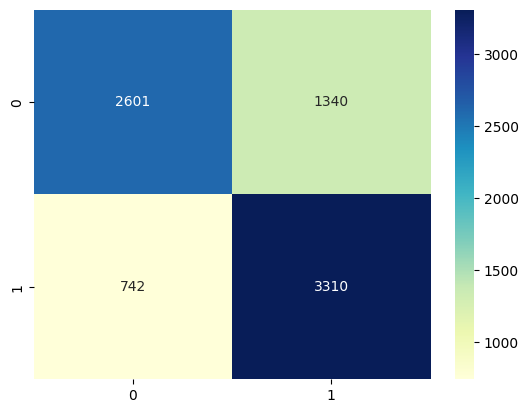

In [37]:
# Confusion matrix using pandas crosstab
conf_matrix= confusion_matrix(y_test, y_pred)#, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='d')

In [39]:
# Printing error metrics
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

Accuracy:  0.7395220818215938
Precision:  0.7118279569892473
Recall:  0.8168805528134254
F1:  0.7607446564008274


## Training other (untuned) classification model

In [40]:
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "Support Vector Machine (RBF Kernel)": SVC(),
    "Neural Network": MLPClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Adptative Boosting": AdaBoostClassifier(),
    "Extreme Gradient Boosting": XGBClassifier()
}

for name, model in models.items():
    #Pipeline of the whole prediction
    model_classification = Pipeline([
        ('transformer', transformer),
        ('model', model)
        ])
    model_classification.fit(X_train, y_train)
    #print(name + " trained.")
    y_pred = model_classification.predict(X_test)
    print(name + ": {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Logistic Regression: 73.95%
K-Nearest Neighbors: 72.91%
Decision Tree: 71.71%
Support Vector Machine (Linear Kernel): 73.78%
Support Vector Machine (RBF Kernel): 76.89%


/Users/sari_dico/Documents/Javier/Capstone_Project_PreHITctor/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network: 79.71%
Random Forest: 80.26%
Gradient Boosting: 79.17%
Stochastic Gradient Descent: 73.78%


/Users/sari_dico/Documents/Javier/Capstone_Project_PreHITctor/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Adptative Boosting: 76.69%
Extreme Gradient Boosting: 81.37%


Between the untuned models, the best accuracy was found in Extreme Gradient Boosting, Random Forest, and Neural Network. By GridSeach the best hyperparemeter of these algorithms are going to be found in order to try to improve the accuracy

### 1.  Hyperparameter Tuning on Extreme Gradient Boosting

In [41]:
# uncomment and run the following script if you want to find the hyperparemeter of this model.
# #variable for the model
# XGB_reg = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)


# #defiying pipeline : transformation + modelling
# model_XGB_reg = Pipeline(steps=[
#     ('transformer', transformer),
#     ('XGB_reg', XGB_reg)
# ])

# param_grid = {
#     'XGB_reg__n_estimators': [100, 200, 300],
#     'XGB_reg__learning_rate': [0.01, 0.05, 0.1],
#     'XGB_reg__max_depth': [3, 4, 5, 6],
#     'XGB_reg__min_child_weight': [1, 3, 5],
#     'XGB_reg__gamma': [0, 0.1, 0.2],
#     'XGB_reg__subsample': [0.6, 0.8, 1.0],
#     'XGB_reg__colsample_bytree': [0.6, 0.8, 1.0],
#     'XGB_reg__reg_alpha': [0, 0.01, 0.1],
#     'XGB_reg__reg_lambda': [1, 10, 100]

# }

# grid_search = GridSearchCV(estimator=model_XGB_reg, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=3, verbose=2)

# grid_search.fit(X_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best accuracy score: ", grid_search.best_score_)

After running the previous script these are the results with the hyperparameters of the model:
#### Best Hyperparameters found for Extreme Gradient Boosting**:
{'XGB_reg__colsample_bytree': 0.8,
 'XGB_reg__gamma': 0,
 'XGB_reg__learning_rate': 0.1,
 'XGB_reg__max_depth': 5,
 'XGB_reg__min_child_weight': 3,
 'XGB_reg__n_estimators': 300,
 'XGB_reg__reg_alpha': 0.1,
 'XGB_reg__reg_lambda': 1,
 'XGB_reg__subsample': 0.6}

### Using the best parameters found

In [41]:
#Adjusting the model with the best parameters
XGB_reg = XGBClassifier(colsample_bytree= 0.8, gamma=0, learning_rate= 0.1, max_depth=5, min_child_weight= 3, n_estimators= 300, reg_alpha=0.1, reg_lambda=1, subsample=0.6, objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

#defiying pipeline : transformation + modelling
model_XGB_reg = Pipeline(steps=[
    ('transformer', transformer),
    ('XGB_reg', XGB_reg)
])

#adjusting the model
model_XGB_reg.fit(X_train, y_train)

#print(name + " trained.")
y_pred = model_XGB_reg.predict(X_test)
print("Extreme Gradient Boosting accuracy" + ": {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

/Users/sari_dico/Documents/Javier/Capstone_Project_PreHITctor/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:57:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Extreme Gradient Boosting accuracy: 81.57%


#### Saving the best model to be used in the streamlit application ####

In [34]:
# uncomment the following line of code if you want to save the model. It is already saved in the folder "models" as "prehitctors.pkl"
#pickle.dump(model_XGB_reg, open('prehitctors.pkl', 'wb'))

### 2.    Hyperparameter Tuning on Random Forest

In [47]:
# uncomment and run the following script if you want to find the hyperparemeter of this model.
# #variable for the model
# random_reg = RandomForestClassifier(random_state=42)

# #defiying pipeline : transformation + modelling
# model_random_reg = Pipeline(steps=[
#     ('transformer', transformer),
#     ('random_reg', random_reg)
# ])

# param_grid = {
#     'random_reg__n_estimators': [100, 200, 300, 400, 500],
#     'random_reg__max_depth': [None, 10, 20, 30, 40, 61],
#     'random_reg__min_samples_split': [2, 5, 10],
#     'random_reg__min_samples_leaf': [1, 2, 4],
#     'random_reg__max_features': ['auto', 'sqrt', 'log2'],
#     'random_reg__bootstrap': [True, False]
# }

# grid_search = GridSearchCV(estimator=model_random_reg, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=3, verbose=2)
# grid_search.fit(X_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best accuracy score: ", grid_search.best_score_)

After running the previous script these are the results with the hyperparameters of the model:

#### Best Hyperparameters found for Randm Forest: 
{'random_reg__bootstrap': False,
 'random_reg__max_depth': 30,
 'random_reg__max_features': 'log2',
 'random_reg__min_samples_leaf': 1,
 'random_reg__min_samples_split': 2,
 'random_reg__n_estimators': 400}

### Using the best parameters found

In [42]:
#Adjusting the model with the best parameters
random_reg = RandomForestClassifier(random_state=42, max_depth=30, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=400)

#defiying pipeline : transformation + modelling
model_random_reg = Pipeline(steps=[
    ('transformer', transformer),
    ('random_reg', random_reg)
])

#adjusting the model
model_random_reg.fit(X_train, y_train)

#print(name + " trained.")
y_pred = model_random_reg.predict(X_test)
print("Random Forest accuracy" + ": {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Random Forest accuracy: 80.58%


### 3.   Hyperparameter Tuning on ANN

In [49]:
# uncomment and run the following script if you want to find the hyperparemeter of this model.
# #variable for the model
# ANN_reg = MLPClassifier(random_state=42)

# #defiying pipeline : transformation + modelling
# model_ANN_reg = Pipeline(steps=[
#     ('transformer', transformer),
#     ('ANN_reg', ANN_reg)
# ])

# param_grid = {
#     'ANN_reg__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
#     'ANN_reg__activation': ['tanh', 'relu'],
#     'ANN_reg__solver': ['sgd', 'adam'],
#     'ANN_reg__alpha': [0.0001, 0.001, 0.01],
#     'ANN_reg__learning_rate': ['constant', 'adaptive'],
#     'ANN_reg__learning_rate_init': [0.001, 0.01, 0.1],
#     'ANN_reg__max_iter': [200, 400],
#     'ANN_reg__batch_size': [32, 64],
#     'ANN_reg__momentum': [0.9, 0.95],
#     'ANN_reg__early_stopping': [True, False]
# }

# grid_search = GridSearchCV(estimator=model_ANN_reg, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=3, verbose=2)

# grid_search.fit(X_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best accuracy score: ", grid_search.best_score_)

After running the previous script these are the results with the hyperparameters of the model:

#### Best Hyperparameters found for Artificial Neural Network: 
{'ANN_reg__activation': 'relu',
 'ANN_reg__alpha': 0.0001,
 'ANN_reg__batch_size': 64,
 'ANN_reg__early_stopping': False,
 'ANN_reg__hidden_layer_sizes': (50,),
 'ANN_reg__learning_rate': 'constant',
 'ANN_reg__learning_rate_init': 0.001,
 'ANN_reg__max_iter': 400,
 'ANN_reg__momentum': 0.9,
 'ANN_reg__solver': 'adam'}

### Using the best parameters found

In [43]:
#Adjusting the model with the best parameters
ANN_reg = MLPClassifier(random_state=42, activation='relu', alpha=0.0001, batch_size=64, early_stopping=False, hidden_layer_sizes=(50,), learning_rate='constant', learning_rate_init= 0.001, max_iter=400, momentum=0.9, solver='adam')

#defiying pipeline : transformation + modelling
model_ANN_reg = Pipeline(steps=[
    ('transformer', transformer),
    ('ANN_reg', ANN_reg)
])

#adjusting the model
model_ANN_reg.fit(X_train, y_train)

#print(name + " trained.")
y_pred = model_ANN_reg.predict(X_test)
print("Neural Network accuracy" + ": {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Neural Network accuracy: 80.36%
